In [1]:
import csv
import numpy as np
import os
import math
import random
random.seed(42)
np.random.seed(42)
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from surprise import Reader
from surprise import AlgoBase
from surprise import Dataset
from surprise import accuracy
from collections import defaultdict
from sklearn.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans,NMF,SVD

In [2]:
file_ratings=os.path.expanduser('ml-latest-small/ratings.csv')
file_movies=os.path.expanduser('ml-latest-small/movies.csv')

user_id=[]
movie_id=[]
ratings=[]

with open(file_ratings) as csvfile:
    reader=csv.DictReader(csvfile)
    for row in reader:
        user_id.append(int(row['userId']))
        movie_id.append(int(row['movieId']))
        ratings.append(float(row['rating']))
        
user_number=len(np.unique(user_id))
movie_number=len(np.unique(movie_id))
movie_list=dict()
movie_id_u=[]
movie_idx=0
for id in movie_id:
    if id not in movie_id_u:
        movie_list[id]=int(movie_idx)
        movie_id_u.append(id)
        movie_idx=movie_idx+1
        
total_available_rating=len(user_id)
total_possible_rating=user_number*movie_number

In [3]:
R=np.zeros((user_number, movie_number))  
W=np.zeros((user_number, movie_number))

for i in range(len(user_id)):
    x=user_id[i]-1
    y=int(movie_list[movie_id[i]])
    R[x,y]=ratings[i]
    W[x,y]=1
np.sum(R,axis=0)
x=np.sum(W,axis=0)
rating=np.sum(R,axis=0)/np.sum(W,axis=0)
for i in range(movie_number):
    if x[i]<200:
        rating[i]=5 
movie_id_u[np.argmin(rating)]

data=[]
data.append(user_id)
data.append(movie_id)
data.append(ratings)
data=np.transpose(data)
data

def Popular(test_index, movieFreq):
    new_index=[]
    for index in test_index:
        if movieFreq[movie_list[data[index,1]]]>2:
            new_index.append(index)
    return new_index

def Unpopular(test_index, movieFreq):
    new_index=[]
    for index in test_index:
        if movieFreq[movie_list[data[index,1]]]<=2:
            new_index.append(index)
    return new_index

def HighVariance(testset, movieFreq, movieVar):
    new_index=[]
    for index in test_index:
        if movieVar[movie_list[data[index,1]]]>=2 and movieFreq[movie_list[data[index,1]]]>=5:
            new_index.append(index)            
    return new_index

movieFreq=np.sum(R!=0, axis=0)
movieFreq_dict={m: movieFreq[movie_list[m]] for m in movie_list.keys()}
movieVar=[np.var([e for e in row if e!=0]) for row in np.transpose(R)]
movieVar_dict={m: movieVar[movie_list[m]] for m in movie_list.keys()}

# Question 30

In [4]:
averageRMSE=0
RMSE_list=[]

kf=KFold(n_splits=10,random_state=42,shuffle=True)
avg=np.sum(R,axis=1)/np.sum(W,axis=1)
print(R.shape)
print(avg.shape)

for train_index, test_index in kf.split(data):
    RMSE=0
    for index in test_index:
        pred=avg[int(data[index,0]-1)]
        RMSE=RMSE+(data[index,2]-pred)*(data[index,2]-pred)
    averageRMSE=averageRMSE+math.sqrt(RMSE/len(test_index))   
    RMSE_list.append(math.sqrt(RMSE/len(test_index)))
    
averageRMSE=averageRMSE/10  
print('averageRMSE=',averageRMSE)

(610, 9724)
(610,)
averageRMSE= 0.9346786847813551


# Question 31

In [5]:
averageRMSE_popular=0
RMSE_list=[]

for train_index, test_index in kf.split(data):
    RMSE=0
    new_index=Popular(test_index, movieFreq)
    for index in new_index:
        pred=avg[int(data[index,0]-1)]
        RMSE=RMSE+(data[index,2]-pred)*(data[index,2]-pred)
    averageRMSE_popular=averageRMSE_popular+math.sqrt(RMSE/len(new_index))   
    RMSE_list.append(math.sqrt(RMSE/len(new_index)))
    
averageRMSE_popular=averageRMSE_popular/10    
print('averageRMSE_popular=',averageRMSE_popular)

averageRMSE_popular= 0.9322922328020201


# Question 32

In [6]:
averageRMSE_unpopular=0
RMSE_list=[]

for train_index, test_index in kf.split(data):
    RMSE=0
    new_index=Unpopular(test_index, movieFreq)
    for index in new_index:
        pred=avg[int(data[index,0]-1)]
        RMSE=RMSE+(data[index,2]-pred)*(data[index,2]-pred)
    averageRMSE_unpopular=averageRMSE_unpopular+math.sqrt(RMSE/len(new_index))   
    RMSE_list.append(math.sqrt(RMSE/len(new_index)))
    
averageRMSE_unpopular=averageRMSE_unpopular/10    
print('averageRMSE_unpopular=',averageRMSE_unpopular)

averageRMSE_unpopular= 0.9711408873803059


# Question 33 

In [7]:
averageRMSE_highvariance=0
RMSE_list=[]

for train_index, test_index in kf.split(data):    
    RMSE=0
    new_index=HighVariance(test_index, movieFreq,movieVar)
    for index in new_index:
        pred=avg[int(data[index,0]-1)]
        RMSE=RMSE+(data[index,2]-pred)*(data[index,2]-pred)
    averageRMSE_highvariance=averageRMSE_highvariance+math.sqrt(RMSE/len(new_index))   
    RMSE_list.append(math.sqrt(RMSE/len(new_index)))
    
averageRMSE_highvariance=averageRMSE_highvariance/10    
print('averageRMSE_highvariance=',averageRMSE_highvariance)

averageRMSE_highvariance= 1.4535715353696466


# Question 34 

In [8]:
reader=Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data=Dataset.load_from_file('ml-latest-small/ratings.csv', reader)
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
trainset, testset=train_test_split(data, test_size=0.1)

algo1=KNNWithMeans(k=22, sim_options={'name': 'pearson', 'user_based': True})
algo2=NMF(n_factors=16)
algo3=SVD(n_factors=28)

algo1.fit(trainset)
prediction1 = algo1.test(testset)
algo2.fit(trainset)
prediction2 = algo2.test(testset)
algo3.fit(trainset)
prediction3 = algo3.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


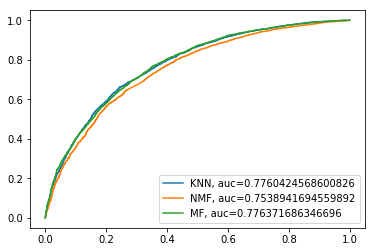

In [9]:
threshold=3
y=[1 if pred[2]>threshold else 0 for pred in prediction1]
scores1=[pred[3] for pred in prediction1]
fpr1, tpr1, _=roc_curve(y, scores1)
auc1=roc_auc_score(y, scores1)
plt.plot(fpr1,tpr1,label="KNN, auc="+str(auc1))

y=[1 if pred[2]>threshold else 0 for pred in prediction2]
scores2=[pred[3] for pred in prediction2]
fpr2, tpr2, _=roc_curve(y, scores2)
auc2 = roc_auc_score(y, scores2)
plt.plot(fpr2,tpr2,label="NMF, auc="+str(auc2))

y=[1 if pred[2]>threshold else 0 for pred in prediction3]
scores3=[pred[3] for pred in prediction3]
fpr3, tpr3, _=roc_curve(y, scores3)
auc3=roc_auc_score(y, scores3)
plt.plot(fpr3,tpr3,label="MF, auc="+str(auc3))

plt.legend(loc=0)
plt.show()

In [10]:
from surprise.model_selection import KFold
def precision_recall_at_k(predictions, k=10, threshold=3):
    user_est_true=defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions=dict()
    recalls=dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel=sum((true_r>=threshold) for (_, true_r) in user_ratings)
        n_rec_k=sum((est>=threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k=sum(((true_r>=threshold) and (est>=threshold))
                              for (est, true_r) in user_ratings[:k])
        precisions[uid]=n_rel_and_rec_k/n_rec_k if n_rec_k!=0 else 1
        recalls[uid]=n_rel_and_rec_k/n_rel if n_rel!=0 else 1
    return precisions, recalls

# Question 36

In [15]:
kf=KFold(n_splits=10)
Precision_KNN=[]
Recall_KNN=[]

for t in range(1,26):
    psum=0
    rsum=0
    if(t%5==0):
        print("t", t)
    for trainset, testset in kf.split(data):
        algo1.fit(trainset)
        prediction1=algo1.test(testset)
        precision1, recall1=precision_recall_at_k(prediction1, k=t, threshold=3)
        psum=psum+sum(prec for prec in precision1.values())/len(precision1)
        rsum=rsum+sum(rec for rec in recall1.values())/len(recall1)

    psum=psum/10
    rsum=rsum/10
    Precision_KNN.append(psum)
    Recall_KNN.append(rsum)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

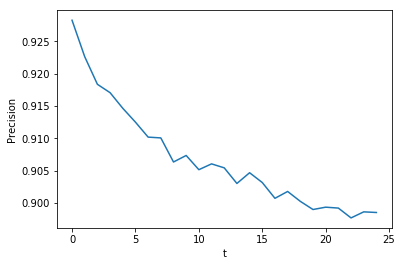

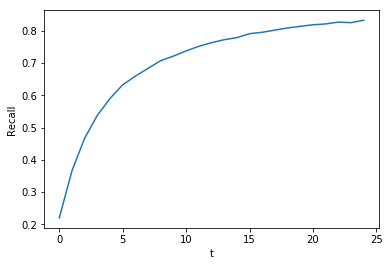

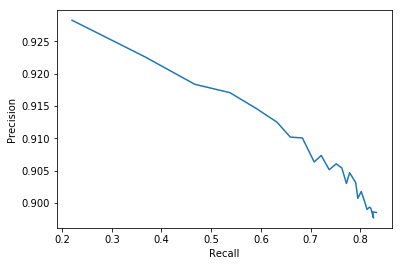

In [16]:
plt.plot(Precision_KNN)
plt.xlabel('t')
plt.ylabel('Precision')
plt.show()

plt.plot(Recall_KNN)
plt.xlabel('t')
plt.ylabel('Recall')
plt.show()

plt.plot(Recall_KNN, Precision_KNN)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Question 37 

In [30]:
Precision_NMF=[]
Recall_NMF=[]

for t in range(1,26):
    psum=0
    rsum=0
    if(t%5==0):
        print("t", t)
    for trainset, testset in kf.split(data):
        algo2.fit(trainset)
        prediction2=algo2.test(testset)
        precision2, recall2=precision_recall_at_k(prediction2, k=t, threshold=3)
        psum=psum+sum(prec for prec in precision2.values())/len(precision2)
        rsum=rsum+sum(rec for rec in recall2.values())/len(recall2)

    psum=psum/10
    rsum=rsum/10
    Precision_NMF.append(psum)
    Recall_NMF.append(rsum)

t 5
t 10
t 15
t 20
t 25


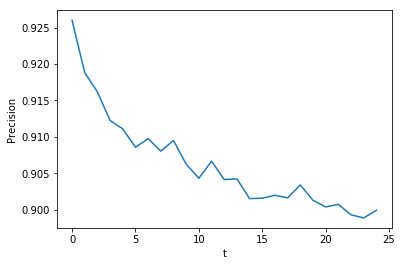

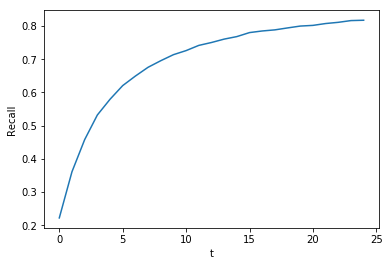

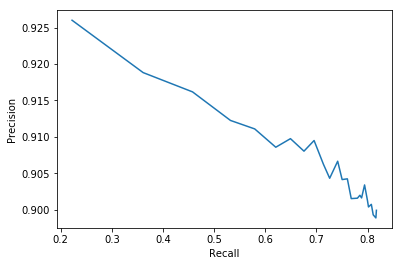

In [31]:
plt.plot(Precision_NMF)
plt.xlabel('t')
plt.ylabel('Precision')
plt.show()

plt.plot(Recall_NMF)
plt.xlabel('t')
plt.ylabel('Recall')
plt.show()

plt.plot(Recall_NMF, Precision_NMF)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Question 38 

In [19]:
Precision_MF=[]
Recall_MF=[]

for t in range(1,26):
    psum=0
    rsum=0
    if(t%5==0):
        print("t", t)
    for trainset, testset in kf.split(data):
        algo3.fit(trainset)
        prediction3=algo3.test(testset)
        precision3, recall3=precision_recall_at_k(prediction3, k=t, threshold=3)
        psum=psum+sum(prec for prec in precision3.values())/len(precision3)
        rsum=rsum+sum(rec for rec in recall3.values())/len(recall3)

    psum=psum/10
    rsum=rsum/10
    Precision_MF.append(psum)
    Recall_MF.append(rsum)

t 5
t 10
t 15
t 20
t 25


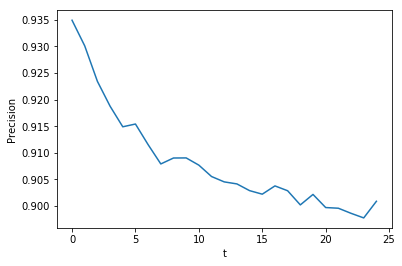

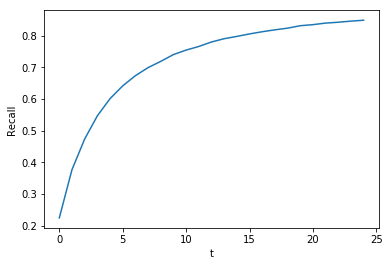

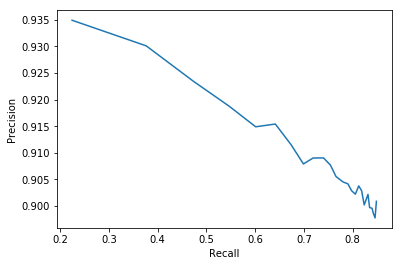

In [21]:
plt.plot(Precision_MF)
plt.xlabel('t')
plt.ylabel('Precision')
plt.show()

plt.plot(Recall_MF)
plt.xlabel('t')
plt.ylabel('Recall')
plt.show()

plt.plot(Recall_MF, Precision_MF)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Question 39 

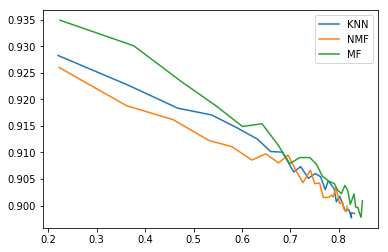

In [35]:
plt.plot(Recall_KNN, Precision_KNN,label="KNN")
plt.plot(Recall_NMF, Precision_NMF,label="NMF")
plt.plot(Recall_MF, Precision_MF,label="MF")
plt.legend(loc=0)
plt.show()